<a href="https://colab.research.google.com/github/navyajain4/CS506-Spring2023/blob/main/CS585_PS2_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 585 Problem Set 2 (Total points: 70])

Assignment adapted from Svetlana Lazebnik.

**Instructions**
1.   Assignment is due at 11:59 PM on Thursday March 2nd 2023.
2.   Submission instructions:

     A. A single .pdf report that contains your work for Q1 and Q2. You can either type out your responses in LaTeX or google document. Lastly, please convert your work into a PDF.

       The PDF file should be submitted to Gradescope under PS2. Please tag the reponses in your PDF with the Gradescope questions outline as described in Submitting an Assignment.

     B. You also need to submit your code in the form of a single .py file in the same directory. You can convert this notebook to Python code by downloading the .ipynb file as Python(.py). Code should also be submitted to Gradescope under PS2-Code. Not submitting your code will lead to a loss of 100% of the points for implementation.

     C. Both Q1 and Q2 require you to evaluate your implemented models on held-out test data. You will need to submit the generated outputs ("Q1_label_predictions.npy" and "Q2_surface_predictions.npy") in the PS2-Code directory as well.

     D. We reserve the right to take off points for not following submission instructions. In particular, please tag the reponses in your PDF with the Gradescope questions outline as described in [Submitting an Assignment](https://www.youtube.com/watch?v=u-pK4GzpId0).
   

#**Q1: Cifar-10 class predictions**

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You may be asked to copy and paste an authentication code.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls

gdrive	sample_data  taskonomy_resize_128_release.zip


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder).

In [ ]:
import os

if not os.path.exists("/content/gdrive/My Drive/1_spring_23/585/Homeworks/pset2"):
    os.makedirs("/content/gdrive/My Drive/1_spring_23/585/Homeworks/pset2")
os.chdir("/content/gdrive/My Drive/1_spring_23/585/Homeworks/pset2")

#commented initially mentioned code, changed directory
#if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2"):
#    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")
#os.chdir("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")

In [ ]:
!ls # Check if this is your PS2 folder

 baseline_result.png		    point_1_view_6_domain_rgb.png
 cifar10_arch.png		   'PS2 notes.ipynb'
 cifar10.png			    Q1_label_predictions.npy
 cifar10_splits			    Q2_surface_predictions.npy
 CS585_PS2.ipynb		    q2_visualization.pdf
 CS585_PS2_sol.ipynb		    taskonomy_resize_128_release
 mp4_q1_plot.png		    taskonomy_resize_128_release.zip
 Navya_report_v1.gdoc		    upload_steps.png
 Navya_Report_v2.gdoc		    visualization_r18.png
 point_1_view_6_domain_normal.png   vis_valset.pdf


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Make sure that pytorch is installed and works with GPU:

In [ ]:
import torch
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class CIFAR10Test(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None,
    ):
        super(CIFAR10Test, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'cifar10_test_images.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 4
        assert images.shape[0] == 2000
        assert images.shape[1] == 32
        assert images.shape[2] == 32
        assert images.shape[3] == 3

        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if is_gpu:
              images = images.cuda()
              labels = labels.cuda()
          outputs = model(Variable(images))
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(list(predicted.cpu().numpy()))
          total += labels.size(0)
          correct += (predicted == labels).sum()

          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].cpu()
              class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))
        
    return predictions



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized CIFAR10 training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .npy file for submission to Gradescope

In [ ]:
import os
print(os.getcwd())

/content/gdrive/My Drive/1_spring_23/585/Homeworks/pset2


In [ ]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
#EPOCHS = 15
EPOCHS = 70
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 32
PATH_TO_CIFAR10 = "cifar10_splits/"
PATH_TO_CIFAR10_TEST = "cifar10_splits/"

1.**Loading CIFAR-10**

We will load the CIFAR-10 dataset with builtin dataset loader from Torchvision. We also created our own train, validation and test splits. You can download them using this link: https://drive.google.com/file/d/1VkiwqowKrNMe6l3wV7-d6FIU3PENpcsI/view?usp=sharing . Upload the file to colab.

We provide a screenshot below on how and wwhere to upload the required data for both questions.

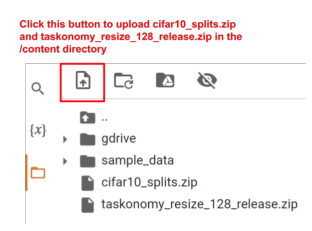

In [ ]:
plt.axis('off')
plt.imshow(Image.open('./upload_steps.png'))

In [ ]:
!unzip -qqo /content/cifar10_splits.zip

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].

# <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).

# ---------------------

#ORIGNAL CODE
#train_transform = transforms.Compose(
#    [transforms.ToTensor()])

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0,1),
      transforms.RandomHorizontalFlip(),
     transforms.RandomCrop([32,32], padding=4)])

test_transform = transforms.Compose(
    [transforms.ToTensor()])
# ---------------------

#DO NOT CHANGE any line below
train_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=False, download=False, transform=test_transform)
test_dataset = CIFAR10Test(root=PATH_TO_CIFAR10_TEST, transform=test_transform)

val_dataset.data = np.load("cifar10_splits/cifar10_val_images.npy")
val_dataset.targets = np.load("cifar10_splits/cifar10_val_labels.npy")
test_dataset.data = np.load("cifar10_splits/cifar10_test_images.npy")

print("train_dataset data shape: ", np.array(train_dataset.data).shape)
print("train_dataset labels shape: ", np.array(train_dataset.targets).shape)
print()
print("val_dataset data shape: ", np.array(val_dataset.data).shape)
print("val_dataset labels shape:", np.array(val_dataset.targets).shape)

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

# The 10 classes for FashionMNIST
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
train_dataset data shape:  (50000, 32, 32, 3)
train_dataset labels shape:  (50000,)

val_dataset data shape:  (8000, 32, 32, 3)
val_dataset labels shape: (8000,)


2.**Visualize CIFAR-10**

We will visualize some random images from the CIFAR-10 dataset.

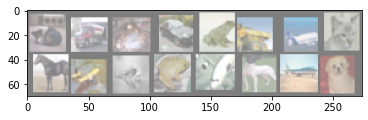

  dog truck  frog automobile  frog truck airplane   cat horse airplane  frog  frog airplane   dog airplane   dog


In [ ]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

3.**Define a Convolution Neural Network**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 32 | 28 | 3 | 6 |
    | 2 | relu | - | 28 | 28 | 6 | 6 |
    | 3 | maxpool2d | 2 | 28 | 14 | 6 | 6 |
    | 4 | conv2d | 5 | 14 | 10 | 6 | 16 |
    | 5 | relu | - | 10 | 10 | 16 | 16 |
    | 6 | maxpool2d | 2 | 10 | 5 | 16 | 16 |
    | 7 | linear | - | 1 | 1 | 400 | 200 |
    | 8 | relu | - | 1 | 1 | 200 | 200 |
    | 9 | linear | - | 1 | 1 | 200 | 10 |

In [ ]:
#CURRENT VERSIONS



class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # TODO: define your model here
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3,padding=1)
        self.bn2 = nn.BatchNorm2d(num_features = 256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(num_features = 512)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 2, padding = 1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(in_features = 4096, out_features = 1024)
        self.bnfc1 = nn.BatchNorm1d(num_features = 1024)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features = 1024, out_features = 256)
        self.bnfc2 = nn.BatchNorm1d(num_features = 256)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(in_features = 256, out_features = 10)

        #pass

    def forward(self, x):

        # TODO: define your model here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = torch.flatten(x,1)

        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.bnfc2(x)
        x = self.fc4(x)
        x = self.fc5(x)
        
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 32, 32))
net.eval()
output = net(dummy_input)
assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

In [ ]:
# TODO: paste output in your report
print(net)

BaseNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

4.**Define a loss function and optimizer**

In [ ]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum = 0.9, weight_decay=0.0)
optimizer = optim.Adam(net.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False)

5.**Train the model**

In [ ]:
########################################################################
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

for epoch in tqdm(range(EPOCHS), total=EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy.cpu())
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')
# -------------

  0%|          | 0/70 [00:00<?, ?it/s]

[1] loss: 1.688
Accuracy of the network on the val images: 51 %
[2] loss: 1.243
Accuracy of the network on the val images: 59 %
[3] loss: 1.031
Accuracy of the network on the val images: 65 %
[4] loss: 0.888
Accuracy of the network on the val images: 71 %
[5] loss: 0.798
Accuracy of the network on the val images: 75 %
[6] loss: 0.723
Accuracy of the network on the val images: 76 %
[7] loss: 0.666
Accuracy of the network on the val images: 77 %
[8] loss: 0.617
Accuracy of the network on the val images: 78 %
[9] loss: 0.580
Accuracy of the network on the val images: 79 %
[10] loss: 0.545
Accuracy of the network on the val images: 80 %
[11] loss: 0.509
Accuracy of the network on the val images: 81 %
[12] loss: 0.484
Accuracy of the network on the val images: 81 %
[13] loss: 0.463
Accuracy of the network on the val images: 81 %
[14] loss: 0.439
Accuracy of the network on the val images: 81 %
[15] loss: 0.416
Accuracy of the network on the val images: 81 %
[16] loss: 0.396
Accuracy of the n

6.**Evaluate the validation accuracy of your final model**

In [ ]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 85.1 %
Accuracy of airplane : 84.3 %
Accuracy of automobile : 91.9 %
Accuracy of  bird : 74.0 %
Accuracy of   cat : 78.8 %
Accuracy of  deer : 78.5 %
Accuracy of   dog : 84.5 %
Accuracy of  frog : 88.6 %
Accuracy of horse : 86.2 %
Accuracy of  ship : 90.9 %
Accuracy of truck : 93.2 %


7.**Visualize test set images**

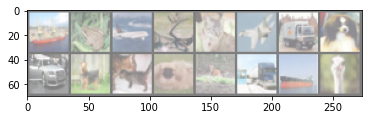

In [ ]:
# get some random training images
dataiter = iter(testloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

In [ ]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)

#**Q2: Surface normal estimation**

In this part, you will build your own surface normal estimation model on a  subset of the Taskonomy dataset. This task comprises of predicting the normal vector at every pixel location. We will be using the mean and median angular error as well as accuracy at 11.25$^{o}, 22.5^{o}, 30.0^{o}$ to measure performance. We provide code for computing these metrics.

In [ ]:
!pwd

/content/gdrive/My Drive/1_spring_23/585/Homeworks/pset2


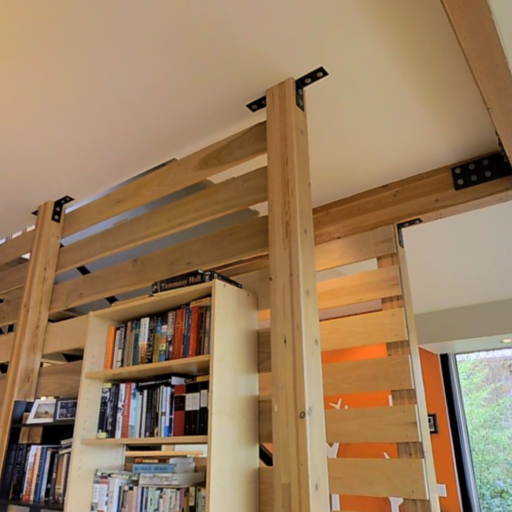

In [ ]:
from IPython.display import Image as show_image
show_image(filename='/content/gdrive/MyDrive/1_spring_23/585/Homeworks/pset2/point_1_view_6_domain_rgb.png') 

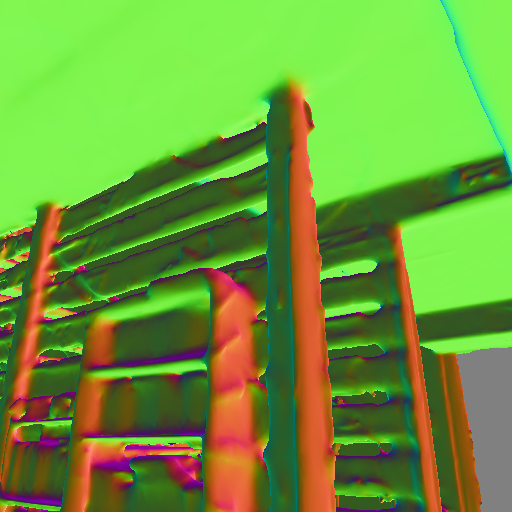

In [ ]:
show_image(filename='/content/gdrive/MyDrive/1_spring_23/585/Homeworks/pset2/point_1_view_6_domain_normal.png')

Data. We have 400 images for training, and 200 images for testing. Each image is 128x128. We provide a basic data loader that you can build upon.

Download the data (taskonomy_resize_128_release.zip) from google drive using this link (https://drive.google.com/file/d/1Y0ikK7f4-C3WYqi6UcdjRI2gwlU3pGGH/view?usp=sharing) and upload it to colab.



In [ ]:
!unzip -qqo /content/taskonomy_resize_128_release.zip

In [ ]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [ ]:
# global variable
device = torch.device("cuda:0")

In [ ]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir="./taskonomy_resize_128_release"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "allensville",
            "val": "beechwood",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal")
        
        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1
        
        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

Build on top of ImageNet pre-trained Model [15 pts]: Once you have a training cycle set up, you should design models for solving the task. To make training faster, we will build a model on top of a ResNet-18 1 model that has been pre-trained on the ImageNet dataset (via models.resnet18(pretrained=True)). These models are trained to predict the 1000 ImageNet object classes. To use this model for surface normal estimation, you will have to remove the classifier and global average pooling layers, and stack on additional layers for surface normal estimation. Note that, ResNet-18 model downsamples the input image by a factor of 32, remeber to upsample your prediction using bilinear interpolation. Since surface normal estimation is not a classification task anymore, you should also play with the loss function. Example of loss functions that you can try are: L1 loss, cosine similarity loss. You can refer to 2 3 for inspiration for how you can build on top of such pre-existing models. Again, carefully document the design choices you make in your report.

For reference, we provide the results obtained from a very simple model.

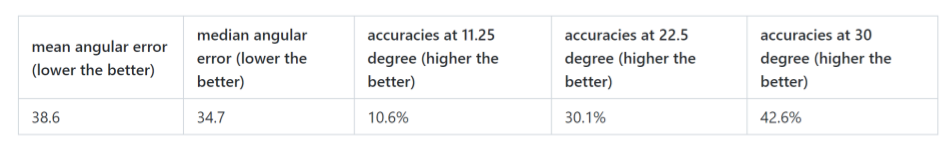

In [ ]:
show_image(filename='/content/gdrive/MyDrive/1_spring_23/585/Homeworks/pset2/baseline_result.png')

In [ ]:
#NOTE - BILINEAR INTERPOLATION REMOVED AND REPLACED BY AN UPSAMPLER BUILT
#code for upsampling using bilinear interpolation:
#x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)

class MyModel(nn.Module):

    def __init__(self): # feel free to modify input paramters
        super(MyModel, self).__init__()

        #removing the last 2 layers from resnet
        resnet = models.resnet18(pretrained = True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

        #adding convolutional layer instead since we need an image output
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=216, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=216, out_channels=3, kernel_size=3, padding=1)

        #decoding layers
        self.deconv1 = nn.ConvTranspose2d(in_channels = 3, out_channels = 216, kernel_size=2, stride=2, padding=0)
        self.deconv2 = nn.Conv2d(in_channels = 216, out_channels = 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features = 512)
        self.deconv3 = nn.Conv2d(in_channels = 512, out_channels = 216, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features = 216)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 216, out_channels = 108, kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(num_features = 108)
        self.deconv5 = nn.Conv2d(in_channels = 108, out_channels = 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features = 64)
        self.deconv6 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size=2, stride=2, padding=0)
        self.bn5 = nn.BatchNorm2d(num_features = 32)
        self.deconv7 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features = 16)
        self.deconv8 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size=2, stride=2, padding=0)
        self.bn7 = nn.BatchNorm2d(num_features = 8)
        self.deconv9 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(num_features = 4)
        self.deconv10 = nn.ConvTranspose2d(in_channels = 4, out_channels = 3, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.bn1(x)
        x = self.deconv3(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.deconv4(x)
        x = self.bn3(x)
        x = self.deconv5(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.deconv6(x)
        x = self.bn5(x)
        x = self.deconv7(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.deconv8(x)
        x = self.bn7(x)
        x = self.relu(x)
        x = self.deconv9(x)
        x = self.bn8(x)
        x = self.relu(x)
        x = self.deconv10(x)
        return x

In [ ]:
# DEFINED L1 LOSS

class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()
        self.loss = nn.L1Loss()

    def forward(self, prediction, target, mask):
        # Apply the mask
        
        #unsqueezing the mask to match dimensions
        mask = torch.unsqueeze(mask,dim=1)
        mask.to(device)

        prediction_mask = prediction * mask
        target_mask = target * mask

        prediction_mask.to(device)
        target_mask.to(device)

        # Compute the L1 loss using the L1Loss function from nn module
        loss = self.loss(prediction_mask, target_mask)
        
        return loss


In [ ]:
def simple_train(model, criterion, optimizer, train_dataloader, epoch, **kwargs):
    model.train()
    
    # Loop over batches in the dataloader
    for batch_idx, (data, target, mask) in enumerate(train_dataloader):
        # Move the data and target tensors to the device (GPU) if available
        data, target, mask = data.to(device), target.to(device), mask.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
       
        
        # Forward pass
        output = model(data)
        #print(output.shape)
        
        # Compute the loss
        loss = criterion(output, target, mask)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print progress every `log_interval` batches
        if batch_idx % kwargs.get('log_interval', 10) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))


In [ ]:
def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

In [ ]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.
import torch.optim as optim
model = MyModel().to(device)
criterion = MyCriterion().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_dataset = NormalDataset(split='train')
train_dataloader = data.DataLoader(train_dataset, batch_size=4, 
                                    shuffle=True, num_workers=2, 
                                    drop_last=True)

num_epochs = 40
for epoch in range(num_epochs):
    simple_train(model, criterion, optimizer, train_dataloader, num_epochs)
    # consider reducing learning rate


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 40 [0/400 (0%)]	Loss: 0.461362
Train Epoch: 40 [40/400 (10%)]	Loss: 0.401385
Train Epoch: 40 [80/400 (20%)]	Loss: 0.400615
Train Epoch: 40 [120/400 (30%)]	Loss: 0.365393
Train Epoch: 40 [160/400 (40%)]	Loss: 0.383930
Train Epoch: 40 [200/400 (50%)]	Loss: 0.349272
Train Epoch: 40 [240/400 (60%)]	Loss: 0.379843
Train Epoch: 40 [280/400 (70%)]	Loss: 0.378423
Train Epoch: 40 [320/400 (80%)]	Loss: 0.369199
Train Epoch: 40 [360/400 (90%)]	Loss: 0.316080
Train Epoch: 40 [0/400 (0%)]	Loss: 0.360970
Train Epoch: 40 [40/400 (10%)]	Loss: 0.352438
Train Epoch: 40 [80/400 (20%)]	Loss: 0.339856
Train Epoch: 40 [120/400 (30%)]	Loss: 0.352500
Train Epoch: 40 [160/400 (40%)]	Loss: 0.344511
Train Epoch: 40 [200/400 (50%)]	Loss: 0.345952
Train Epoch: 40 [240/400 (60%)]	Loss: 0.321534
Train Epoch: 40 [280/400 (70%)]	Loss: 0.358532
Train Epoch: 40 [320/400 (80%)]	Loss: 0.316593
Train Epoch: 40 [360/400 (90%)]	Loss: 0.363016
Train Epoch: 40 [0/400 (0%)]	Loss: 0.312454
Train Epoch: 40 [40/400 (1

Increase your model output resolution [15 pts]: The current model simply replaces the final fully connected layer in a ResNet-18 model for surface normal estimation. This still has a lot of draw backs. The most important factors that causes poor performance is the low output resolution. ResNet-18 model for image classification downsamples the input image by a factor of 32. In the previous step, we recover the resolution by a simple bilinear interpolation layer which upsamples the prediction by 32 times. In this part, our goal is to explore other choices to generate high-resolution predictions. We offer two choices that you can consider: * Atrous (or dilated) convolution. The concept of atrous convolution (or dilated convolution) is described it the DeepLab paper4. One way to think about atrous convolution is to think of running the network on shifted versions of the image and weaving the outputs together to produce an output at the original spatial resolution. This can be done simply by using the dilataion arguments in PyTorch. Refer to the paper4 and PyTorch documentation for more detail. * Building a learned upsampler. Instead of using bilinear upsampling, you can use a decoder that learns to upsample prediction to improve the output quality. The key that makes decoder works better than bilinear interpolation is the usage of skip-connection. Refer to the U-net3 and DeepLabv3+5 for more detail.

You can implement either of these two choices, or other choices you
 find in other papers to increase your model output resolution. Please
 describe the methods you try in your report and report their
 performance.

 **In your report, include:**
- Your best model. Include final performance on validation set (5 metrics).
- An ablation table, listing all factors that you tried to make
  improvement to your final model as well as the validation performance.

# You do not need to change anything below

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2799726627394557
Validation metrics: Mean 37.2, Median 31.8, 11.25deg 22.2, 22.5deg 39.6, 30deg 48.2


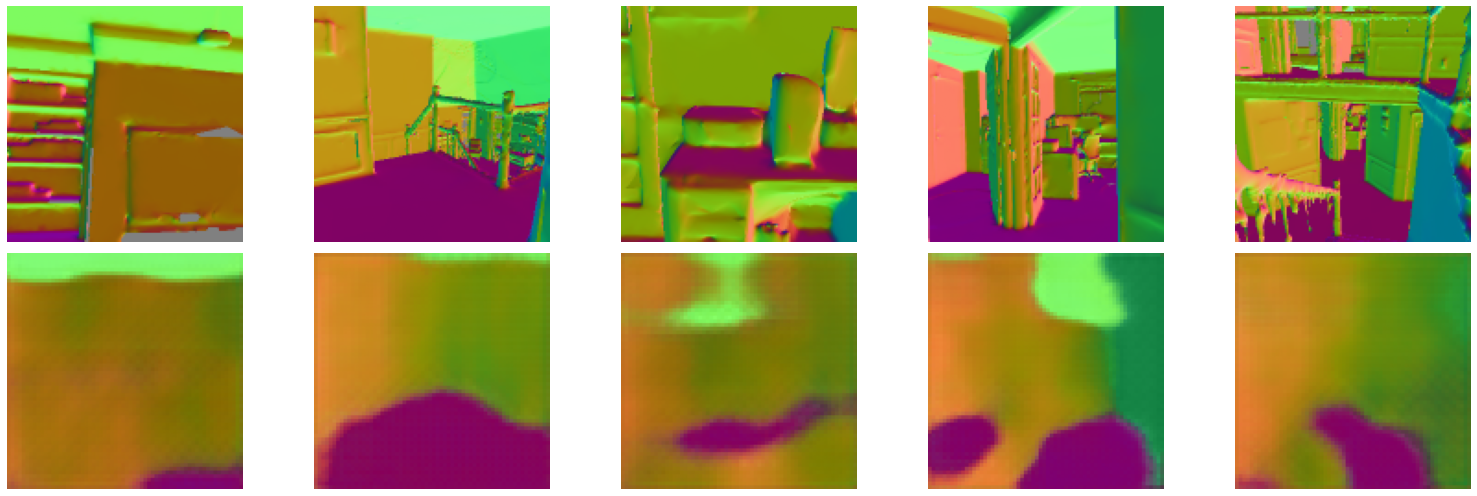

In [ ]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.

def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

  0%|          | 0/200 [00:00<?, ?it/s]

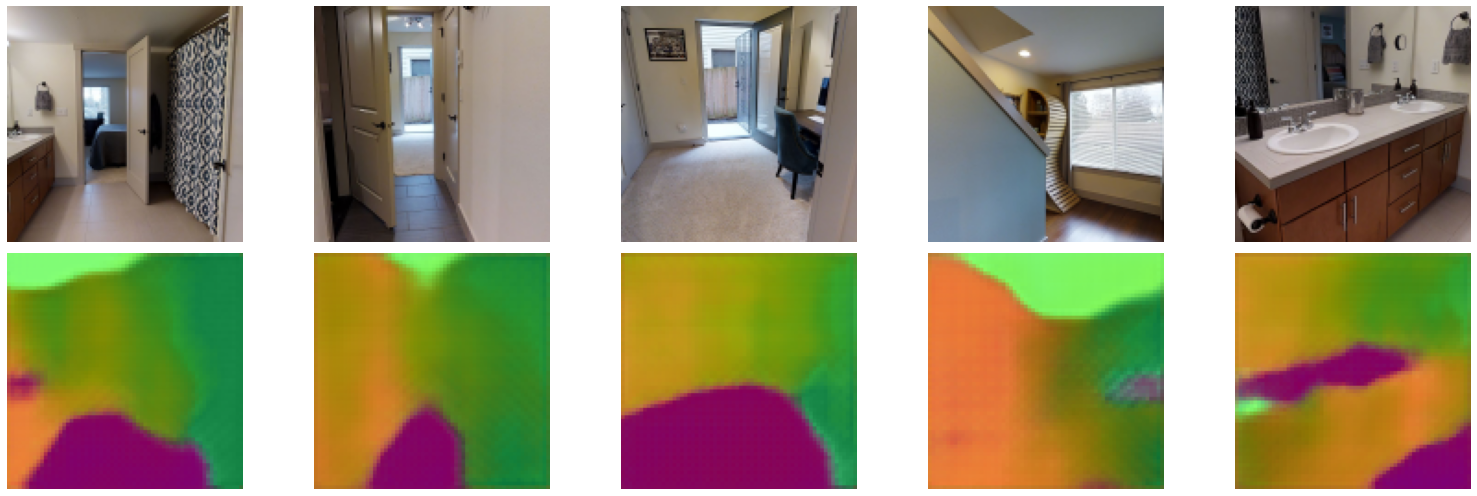

In [ ]:
# Visualization

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./taskonomy_resize_128_release", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext

        self.img_dir = os.path.join(image_dir, "collierville_rgb") 
        
        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_release")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')

Visualize your prediction [5 pts]: In your report, visualize 5 predictions of your model on images in the test set. 
**In your report, include:** 
- visualization of model prediction on five test images
- visual comparisons of the output from part 2 and 3 on 2 images from the 
  validation dataset, discuss your observations.

Test set [5 pts]. We have created a secret test set containing 200 images of indoor pictures from the collierville subset. We provide code that saves your model predictions to a Q2_normal_predictions file. Submit the prediction for your best model to gradescope.

In [ ]:
# Test your model on the test set, submit the output to gradescope

from PIL import Image
import numpy as np

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_release")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)

    saved_predictions = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            saved_predictions.append(pred.cpu())

        saved_predictions = torch.cat(saved_predictions, dim=0)
        return saved_predictions

out_dir = "Q2_normal_predictions"
saved_predictions = simple_test(model, out_dir)
np.save('./Q2_surface_predictions.npy', saved_predictions)

  0%|          | 0/200 [00:00<?, ?it/s]